In [1]:
# Import required libraries, functions, and modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import wrangle
import explore
import model

import warnings
warnings.filterwarnings("ignore")

# Project Objective

### The goal of this project was to predict property tax assessed values of Single Family Properties located in three counties (LA, Orange, and Ventura) in southern California that had a transaction in 2017. 

# Wrangle Zillow Data

- The wrangle_zillow function in the wrangle.py module is used to acquire and prepare the data from the mySQL server or cached csv file. Approximately 52000 rows are returned for the Single Family property type.
- The data is prepared by performing the following:
    - Renaming columns
    - Filling in NaN values for columns such as whether the house has a pool or garage
    - Creating additional feature columns such as:
        - Home age
        - Living space
        - Room count
        - Categorizing bathroom and bedroom counts

In [2]:
df = wrangle.wrangle_zillow()
df.shape

Using cached data


(52442, 20)

- To help focus exploration and modeling on the bulk of the data, outliers 2 standard deviations from the mean value are removed:

In [3]:
df_outlier_removed = wrangle.remove_outliers_std(df, 2.0, ['tax_value','lot_size','bedroom','bathroom','living_space'])
df_outlier_removed = df_outlier_removed.dropna()
df_outlier_removed.shape

Number of observations removed: 4652


(47509, 20)

- The data is split into train, validate, and test sets

In [4]:
train, validate, test = wrangle.split_data(df_outlier_removed)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


### The target variable distribution is shown in the following histogram. 

(9.0, 15.0)

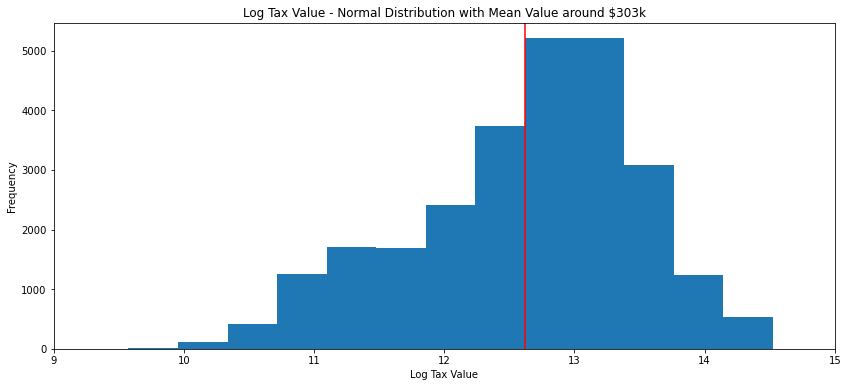

In [5]:
np.log(train.tax_value).plot.hist(bins=20, figsize = (14,6))
plt.xlabel("Log Tax Value")
plt.axvline(np.log(train.tax_value).mean(), color = 'red')
plt.title(f"Log Tax Value - Normal Distribution with Mean Value around $303k")
plt.xlim(9,15)

## Key Drivers of Property Value for Single Family Properties
- Location:
    - Does the property's county affect the tax value?
- Home Size and Usable Space
    - Does the property's square footage affect the tax value?
    - Does the number of bedrooms or number of bathrooms affect the tax value?
    - Does the space outside of bedrooms and bathrooms affect the tax value?
- Age and Condition
    - How does the age of the house affect the tax value?

### Location: does the property's county affects it's tax value?
-> Perform 1 sample t-test

Generating plots tax_value by county


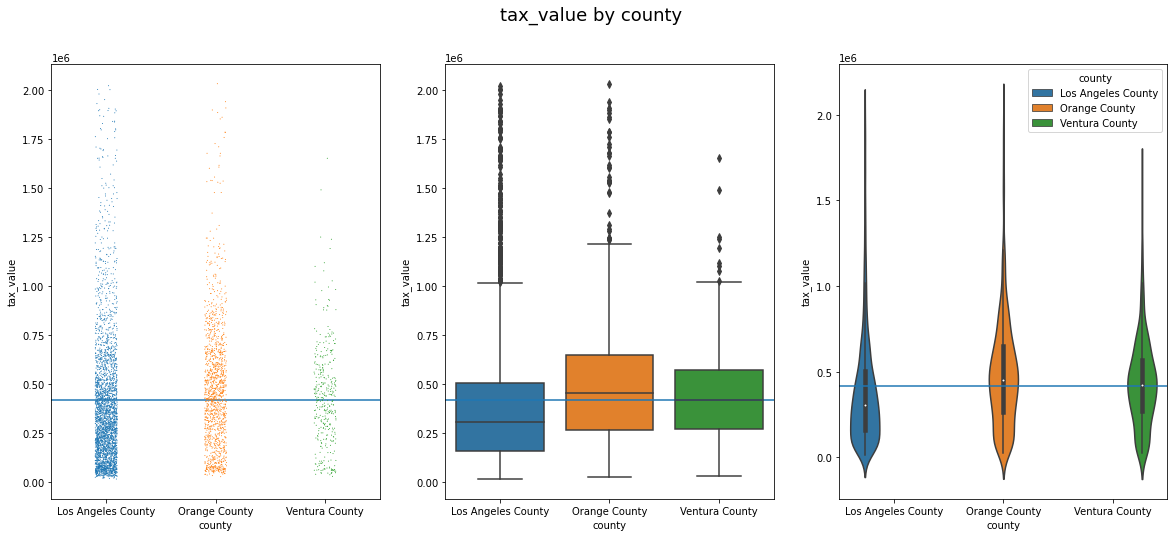

In [6]:
explore.plot_categorical_and_continuous_vars(train, ['county'], ['tax_value'], sample_amt = 5000)

In [7]:
alpha = 0.05
for county in set(train.county):
    sample = train.tax_value[train.county == county]
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    if (p/2 < alpha) and (t>0):
        print(county, " t: ", round(t,2), "Significantly Greater")
        
    t, p = stats.ttest_1samp(sample, train.tax_value.mean())
    
    if (p/2 < alpha) and (t<0):
        print(county, round(t,2), "Significantly Less")

Orange County  t:  17.69 Significantly Greater
Ventura County  t:  5.23 Significantly Greater
Los Angeles County -12.46 Significantly Less


### Based on the t-test results LA County has an average tax value significantly lower than the overall average, while Orange and Ventura counties have higher average tax values. 
- The county will be used as a feature for the model.

## Home Size and Usable Space
- Does the property's square footage affect the tax value?
- Does the number of bedrooms or number of bathrooms affect the tax value?
- Does the space outside of bedrooms and bathrooms affect the tax value?
    - This is defined as Square Footage - (40 * Num Bathrooms) - (200 * Num Bedrooms)

-> Pearson Correlation Tests Performed (all showed linear relationship with tax value is significant)

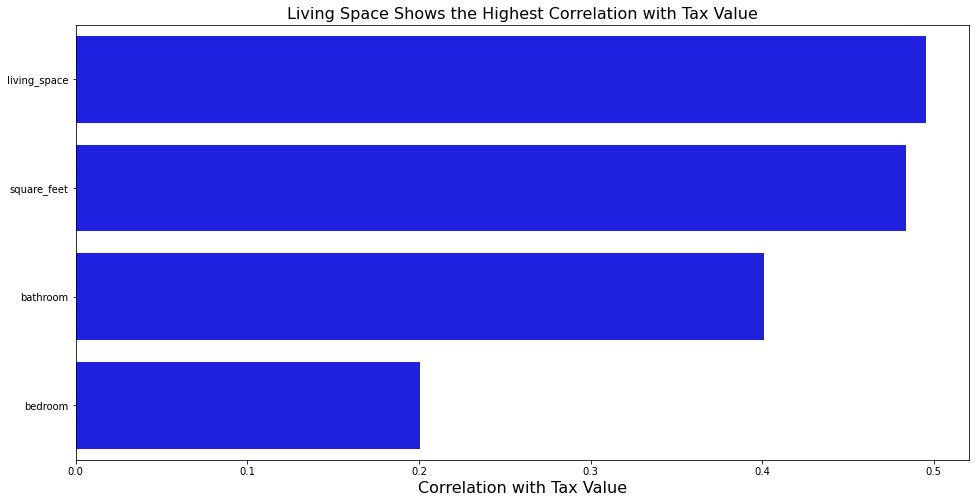

In [8]:
# Plot correlation of living space features to tax value
of_interest = ['tax_value','living_space','square_feet','bathroom','bedroom']
corrs = pd.DataFrame(train[of_interest].drop(columns = ['tax_value']).corrwith(train.tax_value, method = 'pearson').sort_values(ascending=False), columns = ["Correlation"])
plt.figure(figsize = (16,8))
sns.barplot(data = corrs, y = corrs.index, x = corrs.Correlation, color = 'b')
plt.xlabel("Correlation with Tax Value", fontsize = 16)
p=plt.title("Living Space Shows the Highest Correlation with Tax Value", fontsize = 16)

### Both living space and square footage correlate moderately with tax value.

## Age and Condition: How does the age of the house affect the tax value?
- Is this affected by the property's county?

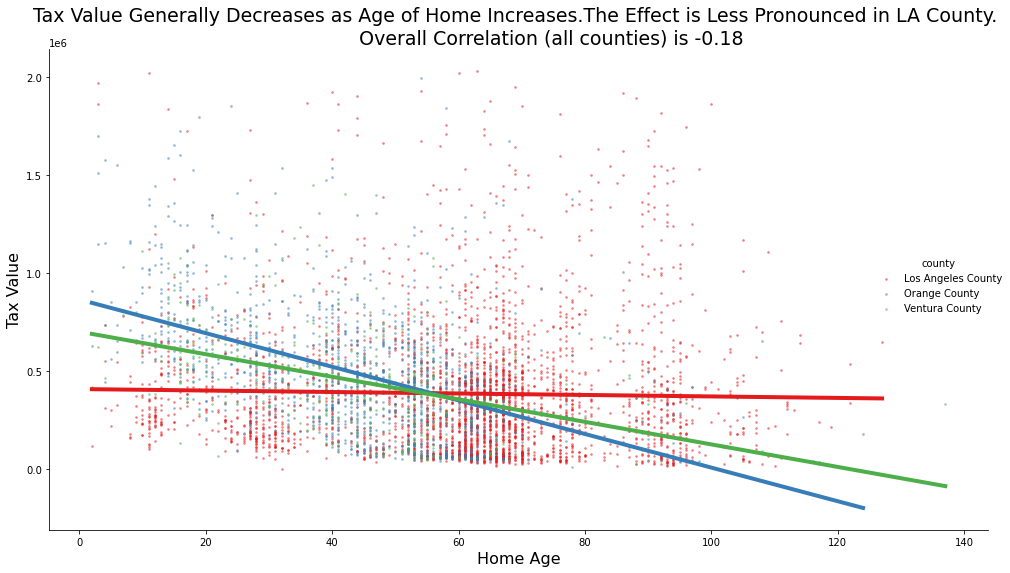

In [9]:
sns.lmplot(data = train.sample(5000), x = 'age', y = 'tax_value', hue = 'county',palette='Set1',
                           scatter_kws={"alpha":0.4, 's':3}, 
                           line_kws={'lw':4},
                           ci = None, height = 8, aspect = 1.5)

plt.title(f"Tax Value Generally Decreases as Age of Home Increases.The Effect is Less Pronounced in LA County. \n \
          Overall Correlation (all counties) is {round(train.corrwith(train.tax_value, method = 'pearson')['age'],2)}", fontsize = 19)
plt.tight_layout()
plt.xlabel('Home Age', fontsize = 16)
plt.ylabel('Tax Value', fontsize = 16)
plt.show()

### Age has a weakly linear correlation with tax value overall, though the property's county affects this relationship.

# Exploration Takeaways:

- Average tax value looks to be higher than the overall average for more than 3 bedrooms and lower for 3 or less:
- Average tax value looks to be higher than the overall average for more than 2 bathrooms and lower for 2 or less
- Seems to be a linear relationship between square feet and tax value
- Having a garage adds value to a home
- The greater the age the lower the value in general
- The county the home is in affects the tax value: LA looks to be less than other two
- Having a pool seems more valuable than not
- See exploration notebook for details behind these conclusions.

# Modeling

- Four regression algorithms evaluated to predict tax value
- Exploration results and recursive feature elimination were used to input the top 3 features to the algorithms
- Based on location being such a factor on tax value separate models were created for each county. This was found to be superior to simple encoding the county.

In [10]:
# These are the features that need to be encoded
to_dummy = ['bedroom_cat','bathroom_cat']
# These are the features that need to be scaled
features_to_scale = ['age','living_space','square_feet','bathroom','bedroom']
# These are the features that will be fed into the model based on exploration
columns_to_use = ['age','living_space','pool','has_garage','square_feet','bathroom','bedroom']

In [11]:
# Test each county with each regression algorithm
all_results = {}
for county in set(train.county):
    # Segment the sample of data for the specific county
    train_sample = train[train.county == county]
    validate_sample = validate[validate.county == county]
    test_sample = test[test.county == county]

    X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features = model.model_feature_selection(train_sample, validate_sample, test_sample, to_dummy, features_to_scale, columns_to_use)
    
    print(county, "Top Features:")
    print(rfe_features)
    all_results[county]=model.model(X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test, rfe_features, show_test = True, print_results = False)

Orange County Top Features:
['has_garage', 'age_scaled', 'living_space_scaled']
Ventura County Top Features:
['living_space_scaled', 'square_feet_scaled', 'bedroom_scaled']
Los Angeles County Top Features:
['age_scaled', 'living_space_scaled', 'bathroom_scaled']


### Some variation in top features between counties. Living space consistent but other 2 are different depending on location.

### Baseline Performance

In [12]:
# Using mean was superior for all counties
for county in set(train.county):
    print(county)
    print('Baseline:',all_results[county].loc['tax_value_pred_mean']['rmse_validate'])

Orange County
Baseline: 324148.76252428343
Ventura County
Baseline: 252917.1074722477
Los Angeles County
Baseline: 324019.8804781751


### Top Models by County, sorted by validate r2 value and RMSE

In [13]:
all_results['Orange County'].sort_values(by='r2_validate',ascending=False).iloc[1:4][['r2_validate','r2_train','rmse_validate','rmse_train']]

,r2_validate,r2_train,rmse_validate,rmse_train
tax_value_pred_glm,0.324615,0.353243,266385.475139,255646.767200
tax_value_pred_lm,0.304700,0.327882,270284.366272,260610.981337
tax_value_pred_lars,0.304683,0.327881,270287.826351,260611.034411


For Orange County: The Tweedie Regressor with Power = 1 and Alpha = 0. Slight dropoff in validate performance from train.

In [14]:
all_results['Los Angeles County'].sort_values(by='r2_validate',ascending=False).iloc[1:4][['r2_validate','r2_train','rmse_validate','rmse_train']]

,r2_validate,r2_train,rmse_validate,rmse_train
tax_value_pred_lm2,0.234551,0.246590,283468.507241,285068.059075
tax_value_pred_lars,0.228683,0.238439,284552.907165,286605.960260
tax_value_pred_lm,0.228264,0.238217,284630.328967,286647.633236


For Los Angeles County: Polynomial Regression with degree 2. Does not appear overfit based on minimal dropoff from train to validate RMSE.

In [15]:
all_results['Ventura County'].sort_values(by='r2_validate',ascending=False).iloc[1:4][['r2_validate','r2_train','rmse_validate','rmse_train']]

,r2_validate,r2_train,rmse_validate,rmse_train
tax_value_pred_glm,0.442120,0.450673,188806.281652,192285.265026
tax_value_pred_lm2,0.433748,0.461046,190217.735865,190461.120528
tax_value_pred_lars,0.433653,0.432806,190233.759955,195387.323729


For Ventura County: The Tweedie Regressor with Power = 1 and Alpha = 0. Also minimal dropoff from train to validate RMSE.

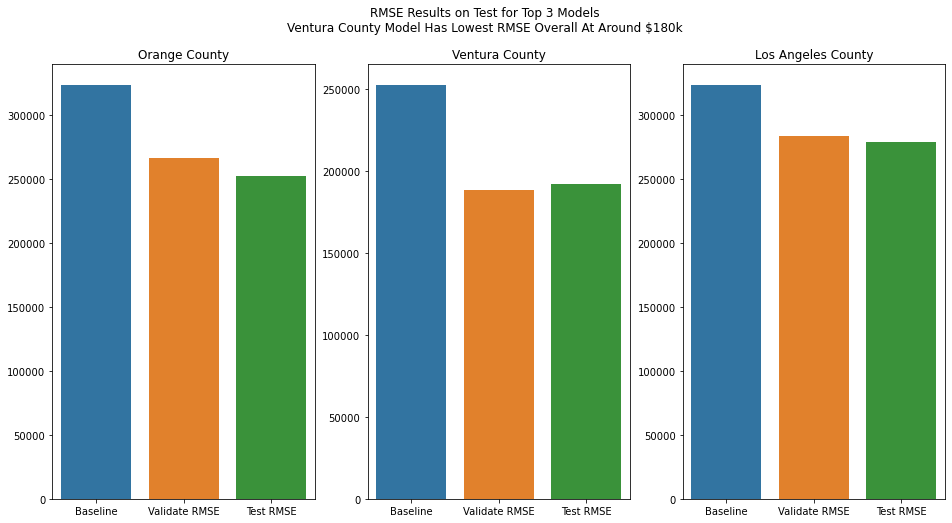

In [36]:
fig, ax = plt.subplots(1,3, figsize = (16,8))

for i, county in enumerate(set(train.county)):
    top = all_results[county].sort_values(by='r2_validate',ascending=False).iloc[1:].head(1)
    sns.barplot(x = ['Baseline','Validate RMSE','Test RMSE'], y = [all_results[county].loc['tax_value_pred_mean']['rmse_validate'], top.rmse_validate.values[0],top.rmse_test.values[0]], ax=ax[i])
    ax[i].set_title(county)
    plt.suptitle('RMSE Results on Test for Top 3 Models\nVentura County Model Has Lowest RMSE Overall At Around $180k')

In [17]:
for county in set(train.county):
    top = all_results[county].sort_values(by='r2_validate',ascending=False).iloc[1:].head(1)
    all_results[county]["pct_diff_from_baseline"] = (all_results[county].loc['tax_value_pred_mean']['rmse_validate'] - top.rmse_test.values[0])/all_results[county].loc['tax_value_pred_mean']['rmse_validate']
    
    print(county, 'Best Improvement Over Baseline:', max(all_results[county]["pct_diff_from_baseline"]))

Orange County Best Improvement Over Baseline: 0.22011856064136565
Ventura County Best Improvement Over Baseline: 0.24088815398191657
Los Angeles County Best Improvement Over Baseline: 0.13935819033641683


# Conclusion and Modeling Summary
- A variety of factors were evaluated using statistical testing to determine drivers of the tax value of homes in 3 southern California counties.
- Location, living space, and age were shown to be moderately correlated with tax value.
- Several regression models were trained and evaluated to attempt to predict tax assessed values of single family properties. Improvements of over 20% over baseline were achieved although r2 and RMSE values were poor enough that I cannot recommend these models for production.
- Additional feature engineering work may help improve performance.
- Ultimately the dataset lacks key information that would likely be more predictive of tax assessed value, such as finer neighborhood information and home condition (although this is available for one county it was not shown to be particularly predictive). 